0.03025044729327568


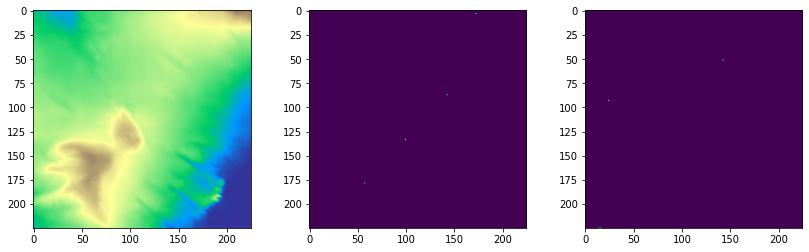

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import math

seed = 2333
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed) 

from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
from matplotlib import colors
from tensorflow.keras.models import load_model
import cv2

import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)
tf.random.set_seed(seed)
with tf.device('/cpu:0'):
    generator = load_model('terrain_generator50000.h5')
    
def proxy(points,show=False):
    if points is None:
        points = []
    source = np.zeros((225,225,2))
    for p in points:
        source[int((p[1]+0.5)*224),int((p[0]+0.5)*224),int(p[2]<0)]=1
    source = source[None]
    w_noise = np.random.normal(0, 1, (1, 14, 14, 1024))
    with tf.device('/cpu:0'):
        predicted = generator.predict([source, w_noise])
    # im = np.uint8(predicted[0, ...] * 127.5 + 127.5) #[-1,1->0,255]
    real_height = predicted[0, ...] 
    real_height = cv2.GaussianBlur(real_height,(5,5),1.0)* 12.5 + 12.5 # -> 0-25cm # smooth
    if show:
        plt.figure(figsize=(14,4))
        plt.subplot(1,3,1)
        plt.imshow(predicted[0],cmap='terrain',norm = colors.Normalize(vmin=-1, vmax=1))
        plt.subplot(1,3,2)
        plt.imshow(source[0,...,0])
        plt.subplot(1,3,3)
        plt.imshow(source[0,...,1])
    elev = real_height[:,:]
    cellsize = 2.5
    px, py = np.gradient(elev, cellsize)
    slope = np.sqrt(px ** 2 + py ** 2)
    slope = np.abs(np.arctan(slope)/np.pi*2)   
    score = 0.3 * np.std(slope) + 0.5 * np.mean(slope)**2 + 0.2 * np.mean(np.abs(elev-np.mean(elev)))/25
    return score

a_dim = 75*75*2+1 # 0:5625, add peak; 5625:11250, add pit; 11250 terminate
def decode_action(i):
    """
    input: int i in range(0,11251)
    return: none for terminate 11250, else normalized 3d vector in [-1, 1]
    """
    if i == 11250:
        return None # terminate
    z = 1 if i < 5625 else -1 # peak or pit
    x = (i%5625)%75
    y = (i%5625)//75
    return [(x-37)/74, (y-37)/74, z]

def encode_state(s):
    """
    input: none for blank, normalized vectors of (n,3) for point lists
    output: a set of used points for action numbers
    """
    if not s:
        return []
    points1 = [int((p[0]*74+37) + (p[1]*74+37)*75) for p in s]
    points2 = [int((p[0]*74+37) + (p[1]*74+37)*75) + 75 * 75 for p in s]
    return points1 + points2

def decode_state(s):
    """
    input: a dict that has keys in range(0,5625) and values in {-1,1}, can be empty
    return: normalized 3-d vectors for each point (element), of shape n*3, can be None for empty dict
    """
    if len(s)==0:
        return None
    keys, values = s.keys(), list(s.values())
    return np.array([[(k%75-37.)/74. for k in keys],[(k//75-37.)/74. for k in keys],values]).T

print(proxy(decode_state({132:1,2222:1,3333:1,4444:1,5555:-1,2333:-1,1322:-1}),show=True))

In [2]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import copy
import random
import time

random.seed(seed) 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 

In [3]:
device0 = torch.device('cuda:0')
class flog(nn.Module):
    def __init__(self,learned_dim=128,num_head=4):
        super(flog, self).__init__()
        self.learned_dim = learned_dim

        self.learned_start = nn.parameter.Parameter(torch.randn(size=(1,learned_dim),device=device0), requires_grad=True)
        self.learned_ter = nn.parameter.Parameter(torch.randn(size=(learned_dim,),device=device0), requires_grad=True)
        
        self.s_embedding = nn.Linear(4, learned_dim, device=device0)
        self.a_embedding = nn.Linear(3, learned_dim, device=device0)
        
        self.s_q1 = nn.Linear(learned_dim, learned_dim, bias=False, device=device0)
        self.s_k1 = nn.Linear(learned_dim, learned_dim, bias=False, device=device0)
        self.s_v1 = nn.Linear(learned_dim, learned_dim, bias=False, device=device0)
        self.s_enc1 = nn.MultiheadAttention(learned_dim, num_head, batch_first=True, device=device0)
        
        self.ff1 = nn.Linear(learned_dim, learned_dim, device=device0)
        
        self.s_q2 = nn.Linear(learned_dim, learned_dim, bias=False, device=device0)
        self.s_k2 = nn.Linear(learned_dim, learned_dim, bias=False, device=device0)
        self.s_v2 = nn.Linear(learned_dim, learned_dim, bias=False, device=device0)
        self.s_enc2 = nn.MultiheadAttention(learned_dim, num_head, batch_first=True, device=device0)
        
        self.ff2 = nn.Linear(learned_dim, learned_dim, device=device0)
        
        self.a_q = nn.Linear(learned_dim, learned_dim, bias=False, device=device0)
        self.a_sk = nn.Linear(learned_dim, learned_dim, bias=False, device=device0)
        self.a_sv = nn.Linear(learned_dim, learned_dim, bias=False, device=device0)        
        self.a_dec = nn.MultiheadAttention(learned_dim, num_head, batch_first=True, device=device0)
        
        self.ffa = nn.Linear(learned_dim, learned_dim, device=device0)
        
        self.output = nn.Linear(learned_dim, 1, device=device0)
        
        # should add a length token, as the fourth dim for 3d vector
        
    def forward(self, s, a):
        """
        batched
        s: (B,n*+1,4), a:(B,3*)
        due to the way I leverage it, s is of same length inside each batch: (B,n,3)
        so that there is no mask
        action: i dont use learned vector, so a is of size (B,3)
        """
        #  I should inject a junk dim at [...,0,...] and replace it
        # so s is of shape (B,n*+1,4), and learned_start of (1,learned_dim)
        s = self.s_embedding(s) # (B,n*+1,d)
        s[:,0:1,:] = self.learned_start.expand(s.shape[0],1,-1)
           
        a = self.a_embedding(a)  # (B,d)
        a = torch.unsqueeze(a,1) # (B,1,d)
        
        s1,_ = self.s_enc1(self.s_q1(s), self.s_k1(s), self.s_v1(s), 
                           need_weights=True) # self attention
#         print(_)
        s1 = s + s1
        s1 = s1 + nn.functional.gelu(self.ff1(s1))
        
        s2,_ = self.s_enc2(self.s_q2(s1), self.s_k2(s1), self.s_v2(s1),
                           need_weights=True) # self attention
        s2 = s1 + s2
        s2 = s2 + nn.functional.gelu(self.ff2(s2))
        
        sa,_ = self.a_dec(self.a_q(a), self.a_sk(s2), self.a_sv(s2),
                          need_weights=True) # cross
        sa = a + sa
        sa = sa + nn.functional.gelu(self.ffa(sa))
        
        est_flog = self.output(sa) # (B,1,1)
        est_flog = est_flog - 6.0  # nightly by zc
        
        return est_flog

    
max_len_traj = 60 # zccc

def preprocess_s(s):
    """
    batched s:(B,n*,3)->(B,n*+1,4)
    inject a junk dim before the first dim
    """
    junk_vec = np.array([[-2,-2,-2,-2]]) # (1,4)
    if s[0]:
        s = np.array(s)  # (B,n,3)
        length_in_batch = len(s[0])
        len_token = np.ones((s.shape[0],s.shape[1],1)) * (length_in_batch/(0.5*max_len_traj) - 1)  # 
        # (B,n,3) -> (B,n,4)
        s_new = np.concatenate([s,len_token],axis=-1)
        # (B,n,4) -> (B,n+1,4)
        junk = np.array([junk_vec for x in s]) # (B,1,4)
        s_new = np.concatenate([junk,s_new],axis=1)

    else:  # s = [None, None,...] -> (B,1,4)
        s_new = np.array([junk_vec for x in s]) # (B,1,4)
    
    output = torch.Tensor(s_new)
    return output

In [4]:
device = torch.device("cuda:0")
model = flog()
model.to('cuda:0')
model = nn.DataParallel(model,device_ids=[0,1,2,3])

In [5]:
epsilon = 1e-6
def rew_shape(r,difficulty='medium'):
    if difficulty == 'medium':
        # better ~ 0.055
        error = np.abs(r-0.055) + 0.005
        rew = epsilon + math.exp(0.1/error - 10)
        return rew

def get_in_flow(s):
    # enumerate s_prev and corresponding a
    # calculate their flows
    # return eps + sum exp flog(s,a)
    assert s is not None
    s_prev = [copy.deepcopy(s) for i in range(len(s))]
    actions = [s[i] for i in range(len(s))]
    _ = [s_prev[i].pop(i) for i in range(len(s))]
    
    s_prev = preprocess_s(s_prev)
    actions = torch.Tensor(actions)   #  parallel
    s_prev.to(device)
    actions.to(device)
    
    sumflow = torch.sum(torch.exp( torch.clamp(model(s_prev,actions), min=-70, max=70) ))  # clamp
    return epsilon + sumflow

def get_out_flow(s):
    # sample potential a \in A(s)
    # get their flows
    # return actions and flogs with ln(ter), can make decision with softmax
    terminate_r = np.log(rew_shape(proxy(s)))
    used_points = encode_state(s)
    a_feas = [x for x in range(11250) if x not in used_points ] # feasible actions
    if len(a_feas)>0 and len(used_points)<max_len_traj*2: # 
#         print(len(used_points))
        actions = [decode_action(i) for i in a_feas]
        repeated_states = [s for i in a_feas]
        
        repeated_states = preprocess_s(repeated_states)
        actions = torch.Tensor(actions)   #  parallel
        repeated_states.to(device)
        actions.to(device)
        
        flogs = torch.clamp(model(repeated_states, actions), min = -70, max = 70)  # clamp
        del actions 
        del repeated_states
        a_feas.append(11250) # add the termination action
        return a_feas, torch.cat([flogs[:,0,0],torch.Tensor([terminate_r]).to(device)])
    else:
        return [11250], torch.Tensor([terminate_r]).to(device)

def decision(a_feas,logs):
    prob = torch.softmax(logs,0).detach().cpu().numpy()
    prob = 0.05 * 1/len(a_feas) + 0.95 * prob
    action = random.choices(a_feas, weights=prob, k=1)[0]
    return decode_action(action)

def trans(s,a):
    if a is None:
        return None
    if s is None:
        return [a]
    snew = copy.deepcopy(s)
    snew.append(a)
    return snew

def sample_traj():
    s0 = None
    s = s0
    action = -1
    while action:
        a, logs = get_out_flow(s)
        action = decision(a,logs)
        del logs
        if action:
            s = trans(s,action)
        else:
            return s

def parse_traj(a):
    # to decompose the list to a sequence of states
    if a:
        return [a[:i] for i in range(1,len(a)+1)]
    else:
        return []
        

def no_explore_decision(a_feas,logs):
    prob = torch.softmax(logs,0).detach().cpu().numpy()
#     prob = 0.05 * 1/len(a_feas) + 0.95 * prob
    action = random.choices(a_feas, weights=prob, k=1)[0]
    return decode_action(action)

def no_explore_sample_traj():
    s0 = None
    s = s0
    action = -1
    while action:
        a, logs = get_out_flow(s)
        action = no_explore_decision(a,logs)
        del logs
        if action:
            s = trans(s,action)
        else:
            return s

def sampled_sum_get_out_flow(s):
    terminate_r = np.log(rew_shape(proxy(s)))
    used_points = encode_state(s)
    a_feas = [x for x in range(11250) if x not in used_points ] # feasible actions
    add_on_num = len(a_feas)  # terminate not included
    if len(a_feas)>0 and len(used_points)<max_len_traj*2: # 
        sampled_a = random.sample(a_feas, k=2000) # zc edit
        actions = [decode_action(i) for i in sampled_a]
        repeated_states = [s for i in sampled_a]
        
        repeated_states = preprocess_s(repeated_states)
        actions = torch.Tensor(actions)   #  parallel
        repeated_states.to(device)
        actions.to(device)
        
        flogs = torch.clamp(model(repeated_states, actions), min = -70, max = 70)  # clamp
        del actions 
        del repeated_states
        return epsilon + np.exp(terminate_r) + torch.sum(torch.exp(flogs)) * add_on_num/len(sampled_a)
    else:
        return torch.sum(torch.Tensor([epsilon + np.exp(terminate_r)]).to(device))

def full_explore_sample_traj(length=max_len_traj):
    s0 = None
    s = s0
    action = -1
    while action:
        used_points = encode_state(s)
        a_feas = [x for x in range(11250) if x not in used_points]
        if len(a_feas)>0 and len(used_points)< length * 2:
            pass
#             a_feas.append(11250) # add the termination action
        else:
            a_feas = [11250]
        
        action = random.choices(a_feas, k=1)[0]
        action = decode_action(action)
        if action:
            s = trans(s,action)
        else:
            return s

In [6]:
memory = []
sampled_terrains = []
crit = nn.MSELoss()
optimizer = optim.SGD(model.parameters(),lr=2e-4)
def get_lr(x):
    return 1
    
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch:get_lr(epoch))
batch_traj = 4 # zcedit

high_quality_cnt = 0
high_quality_terrain = []

writer = SummaryWriter("runs/run-medium")

pre_sample = max_len_traj # 
for i in range(pre_sample):
    for _repeat in range(1):
        print('pre sampling')
        traj = full_explore_sample_traj(i+1)
#         traj = full_explore_sample_traj(max_len_traj)
        memory.append(traj)
        score = proxy(traj)
        writer.add_scalar('sample/score', score, len(memory))
        writer.add_scalar('sample/reshaped_score_log', np.log(rew_shape(score)), len(memory))
        if traj:
            print('sampled a traj of len',len(traj),', score', score,
                  'reshaped score log',np.log(rew_shape(score)), '# traj',len(memory))
        else:
            print('get none traj, score', score, '# traj', len(memory))
        sampled_terrains.append((traj,score))
        if score > 0.06:
            high_quality_cnt += 1
            high_quality_terrain.append(traj)
            print('hit high quality! # high quality terrains:',high_quality_cnt)

pre sampling
sampled a traj of len 1 , score 0.04373634505878156 reshaped score log -3.8512735524474393 # traj 1
pre sampling
sampled a traj of len 2 , score 0.028988798449850747 reshaped score log -6.774483131211926 # traj 2
pre sampling
sampled a traj of len 3 , score 0.03912500264157911 reshaped score log -5.209397231658933 # traj 3
pre sampling
sampled a traj of len 4 , score 0.025447498775471845 reshaped score log -7.104635174375524 # traj 4
pre sampling
sampled a traj of len 5 , score 0.03549220821622543 reshaped score log -5.919292806290146 # traj 5
pre sampling
sampled a traj of len 6 , score 0.029594154020234242 reshaped score log -6.710337581648737 # traj 6
pre sampling
sampled a traj of len 7 , score 0.040657653022767394 reshaped score log -4.829871378500867 # traj 7
pre sampling
sampled a traj of len 8 , score 0.02776964539861975 reshaped score log -6.896345643506232 # traj 8
pre sampling
sampled a traj of len 9 , score 0.04147980301443921 reshaped score log -4.600389868570

In [ ]:
tic = time.time()
while len(memory)<481:
        
    print('walltime: [%.1f s] | sampling...'%(time.time()-tic))
    traj = sample_traj()
    memory.append(traj)
    score = proxy(traj)
    writer.add_scalar('sample/score', score, len(memory))
    writer.add_scalar('sample/reshaped_score_log', np.log(rew_shape(score)), len(memory))
    if traj:
        print('sampled a traj of len',len(traj),', score', score,
              'reshaped score log',np.log(rew_shape(score)), '# traj',len(memory))
        writer.add_scalar('sample/len_traj', len(traj), len(memory))
    else:
        print('get none traj, score', score, '# traj', len(memory))
        writer.add_scalar('sample/len_traj', 0, len(memory))
    sampled_terrains.append((traj,score))
    if score > 0.06:
        high_quality_cnt += 1
        high_quality_terrain.append(traj) # dont use this
        print('hit high quality! # high quality terrains:',high_quality_cnt)

    if len(memory)>=batch_traj:
        print('walltime: [%.1f s] | optimizing...'%(time.time()-tic))
        for _opt_step in range(2):
            aaa = random.sample(memory, k=batch_traj)
            cum_loss = 0
            for x in aaa:
                s_series = parse_traj(x)
                for s in s_series:
                    inward = torch.log(get_in_flow(s))
                    # outward = torch.log(torch.sum(torch.exp(get_out_flow(s)[1]))+epsilon)
                    outward = torch.log(sampled_sum_get_out_flow(s))
                    loss = crit(inward, outward)/batch_traj
                    cum_loss += loss.item() # *batch_traj  # get average
                    loss.backward()
            print('cumulative loss',cum_loss)
            writer.add_scalar('loss/cum_loss'+str(_opt_step), cum_loss, len(memory))
            nn.utils.clip_grad_norm_(model.parameters(), 20, norm_type=2)
            optimizer.step()
            optimizer.zero_grad()
        print('lr',scheduler.get_last_lr())
        scheduler.step()
        
    if len(memory) % 30 == 0:
        print('saving model')
        torch.save(model, "model_para_medium_iter"+str(len(memory))+".pth")

walltime: [0.0 s] | sampling...
sampled a traj of len 60 , score 0.03691970718578767 reshaped score log -5.667010125582973 # traj 61
walltime: [35.8 s] | optimizing...


In [ ]:
s = None
a, fs = get_out_flow(s)
fs = fs.detach().cpu().numpy()
fs = np.exp(fs)
print(fs[0])
fs = fs/fs[-1]

fig = plt.figure()

norm = colors.LogNorm(vmin=min(fs[:-1]), vmax=max(fs[:-1]))
plt.subplot(121)
plt.imshow(np.reshape(fs[:75*75],(75,-1)),norm=norm, cmap=plt.get_cmap('rainbow'))
plt.colorbar()
plt.subplot(122)
plt.imshow(np.reshape(fs[75*75:-1],(75,-1)),norm=norm, cmap=plt.get_cmap('rainbow'))
plt.colorbar()

In [8]:
writer.close()


In [15]:
# memory = memory[:600]
# sampled_terrains = sampled_terrains[:600]
model = torch.load('model_para_medium_iter240.pth')
# model_trained = torch.load('model_para_medium_iter600.pth')
# model = flog(device=device)
# model.load_state_dict(model_trained.state_dict(), strict=False)
optimizer.zero_grad()

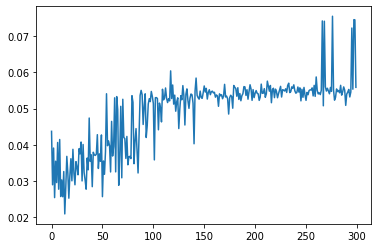

In [14]:
plt.plot([x[-1] for x in sampled_terrains[:300]])

In [17]:
outputs = []
outputs_len = []
for i in range(50):
    _ = no_explore_sample_traj()
    score_ = proxy(_)
    outputs.append(score_)
    outputs_len.append(len(_))
    print(i+1,len(_),score_)

1 3 0.05399254437316829
2 8 0.05579380247190355
3 6 0.05404832103024164
4 18 0.05332537263766977
5 15 0.052570330393314005
6 10 0.05297944272145
7 7 0.05476465917183819
8 6 0.054791848756796324
9 9 0.05361256181627807
10 7 0.053525099084171045
11 17 0.05426453782047696
12 12 0.05460461752656689
13 9 0.053795149168943235
14 8 0.0558190378858319
15 10 0.053831189117438276
16 10 0.0542309037990798
17 8 0.05472485078293657
18 7 0.05418403550203915
19 8 0.05592943926815716
20 8 0.05434788596632036
21 8 0.05518665345905781
22 6 0.05483884590767776
23 19 0.054686574586813363
24 30 0.057874610935281734
25 7 0.054237896841113964
26 18 0.05305050037120487
27 7 0.052980797203134825
28 5 0.055538950507168436
29 6 0.053545695834003385
30 4 0.05452643970859822
31 7 0.05522719796583937
32 7 0.05542023664765847
33 4 0.05490281204706356
34 26 0.057985595459124815
35 24 0.054995840994110576
36 14 0.05274348461791992
37 5 0.054552038265024624
38 20 0.05234182277295196
39 18 0.054030056491931294
40 28 0.0

In [18]:
import pickle
with open('data_medium.pickle', 'wb') as f: 
    pickle.dump({'model':model,'cpt_iter':240,'train_sample':sampled_terrains[:300],'test':(outputs,outputs_len)}, f)

In [19]:
# import pickle
# _ = pickle.load(open("data_medium.pickle",'rb'))
# my_samples = _['train_sample']

In [40]:
# proxy(no_explore_sample_traj(),True)

10
20
30
40
50
60


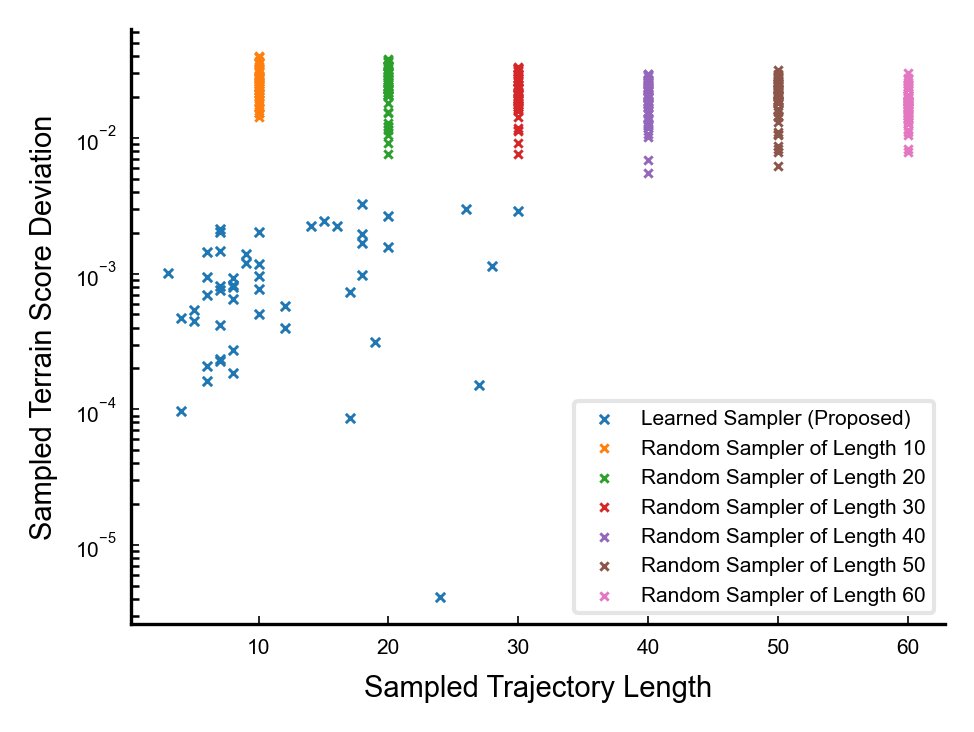

In [41]:
plt.rcParams['figure.dpi'] = 300
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 5}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['lines.linewidth']=0.7
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.major.width']=0.4
plt.rcParams['ytick.major.width']=0.4
plt.rcParams['xtick.major.size']=2
plt.rcParams['ytick.major.size']=2
fig,ax = plt.subplots(figsize=(3.5,3.5*12/16))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.scatter(outputs_len,np.abs([x - 0.055 for x in outputs]),marker='x',s=5,label='Learned Sampler (Proposed)')

def rnd_spl(random_sample_length = 10):
    tmp_ = []
    for i in range(50):
        traj = full_explore_sample_traj(random_sample_length)
        score = proxy(traj)
        tmp_.append(score)
    plt.scatter([random_sample_length for _ in tmp_],np.abs([x - 0.055 for x in tmp_]),marker='x',s=4,label="Random Sampler of Length %d"%random_sample_length)

for _ in range(10,61,10):
    rnd_spl(_)
    print(_)
    
plt.legend(loc=4,framealpha=0.5)
plt.yscale('log')
plt.xlabel('Sampled Trajectory Length',fontsize=7)
plt.ylabel('Sampled Terrain Score Deviation',fontsize=7)
plt.savefig("medium.pdf",dpi=300,bbox_inches='tight')